<h1>EOSC 511: Lab 5b Assignment </h1>
This assignment was written in VS code.


<h2>Problem 5b</h2>
Add foxes that prey on rabbits to Daisy World. By changing the various degrees of freedom in this problem, look for “predator-prey” oscillations, in which the fox and rabbit populations go through periodic highs and lows. Hand-in a discussion and plots describing and showing the most interesting oscillations/longest non-trivial steady state you can find.

<h3> Recreating Rabbit Problem</h3> Since my original lab 5 rabbit problem was not correct, before proceeding with the fox problem I have recreated the provided solution to the rabbit problem.

In [37]:
import context
from collections import namedtuple
from numlabs.lab5.lab5_funs import Integrator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class Integ56(Integrator):

    def set_yinit(self, initb, initw, initr, rabbit_birth, rabbit_eat):

        #read in 'albedo_white chi S0 L albedo_black R albedo_ground'

        uservars=namedtuple('uservars',self.config['uservars'].keys())
        self.config["uservars"]["rabbit_birth"]=initb #change black daisy inputs
        self.config["uservars'][rabbit_eat"]=initw #change white daisy input

        self.uservars=uservars(**self.config['uservars'])

        #read in 'whiteconc blackconc - now as arguments'

        initvars=namedtuple('initvars', self.config['initvars'].keys())
        self.config['initvars']['blackconc']=initb 
        self.config['initvars']["whiteconc"]=initw
        self.config["initvars"]["rabbits"]=initr

        self.initvars=initvars(**self.config["initvars"])

        self.yinit=np.array(
            [self.initvars.whiteconc,self.initvars.blackconc,self.initvars.rabbits])
        self.nvars=len(self.yinit)

        return None

    def __init__(self,coeff_file_name, initb, initw, initr, rabbit_birth, rabbit_eat):
            super().__init__(coeff_file_name)
            self.set_yinit(initb,initw,initr,rabbit_birth,rabbit_eat)

    def find_temp(self,yvals):
        """"calculate the temperature over the white and black daisies
        and the planetary equilibrium temperature given the daisy fractions
        
        input: yvals - and array of dimention[2] with the white[0] and black[0]
        output: white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma=5.67e-8 #Stefan Boltzman constant W/m^2/K^4
        user=self.uservars
        bare=1.0-yvals[0]-yvals[1]
        albedo_p=bare*user.albedo_ground + \
            yvals[0]*user.albedo_white+yvals[1]*user.albedo_black
        Te_4=user.S0/4.0*user.L*(1.0-albedo_p)/sigma
        temp_e=Te_4**0.25
        eta=user.R*user.L*user.S0/(4.0*sigma)
        temp_b=(eta*(albedo_p-user.albedo_black)+Te_4)**0.25
        temp_w=(eta*(albedo_p-user.albedo_white)+Te_4)**0.25
        return(temp_w,temp_b,temp_e)

    def derivs5(self, y,t):
        """y[0]=fraction white daisies
            y[1]=fraction black daisies
            no feedback between daisies and albedo_p
            set to ground albedo
            """
        temp_w, temp_b,temp_e=self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0

        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        # Change these lines to include the amount of daisies eaten by rabbits
        f[0] = y[0] * (beta_w * bare - user.chi) - (y[0] * y[2] * rabbit_eat)
        f[1] = y[1] * (beta_b * bare - user.chi) - (y[1] * y[2] * rabbit_eat)

        # calculate ground covered by daisies to calculate change in rabbit population
        total = y[0] + y[1]
        # Calculate rate of change of rabbits:
        f[2] = y[2] *((rabbit_birth * total * (1.0 - y[2])) - user.rabbit_chi)
        return f

    def timeloop5fixed(self):
        """fixed time step with
            estimated errors
            """
        t = self.timevars
        yold = self.yinit
        yError = np.zeros_like(yold)
        yvals = [yold]
        errorList = [yError]
        timeSteps = np.arange(t.tstart, t.tend, t.dt)
        for theTime in timeSteps[:-1]:
            yold, yError, newTime = self.rkckODE5(yold, theTime, t.dt)
            #pdb.set_trace()
            yvals.append(yold)
            errorList.append(yError)
        yvals = np.array(yvals).squeeze()
        errorVals = np.array(errorList).squeeze()
        return (timeSteps, yvals, errorVals)

In [47]:
import warnings
warnings.filterwarnings("ignore")

def rabbit_solve_plot(initb,initw,initr,rabbit_birth,rabbit_eat):
    theSolver=Integ56('rabbits.yaml', initb=initb, initw=initw, initr=initr, rabbit_birth=rabbit_birth, rabbit_eat=rabbit_eat)
    timeVals, yVals, errorlist=theSolver.timeloop5fixed()
    yvals=pd.DataFrame(yVals,columns=["white","black","rabbits"])

    thefig, theAx = plt.subplots(1, 1,figsize=(10,5))
    points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
    points.set_markersize(12)
    theLine1, = theAx.plot(timeVals, yvals['black'], '--ko', label='black daisies')
    theLine2, = theAx.plot(timeVals, yvals['rabbits'], '--mx', label='rabbits')
    theLine3, = theAx.plot(timeVals, yvals['white'] + yvals['black'], '--c', label='')
    theAx.set_title('lab 5 Predators; initb = ' + str(initb) + '; initw = ' + str(initw)+'; initr= '+ str(initr))
    theAx.set_xlabel('time')
    theAx.set_ylabel('fractional coverage')
    out = theAx.legend(loc='best')
    
    plt.show()


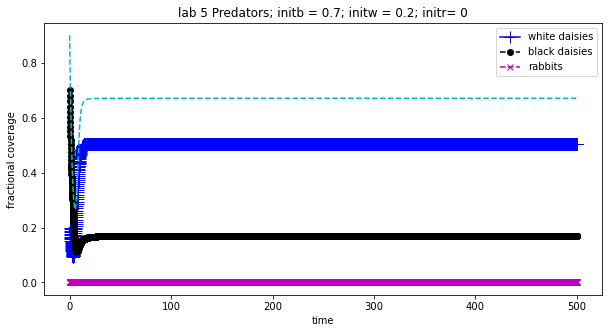

In [48]:
# Test that with zero rabbits it's the same as before
initb=0.7
initw=0.2
initr = 0
rabbit_birth=0.01
rabbit_eat=0.1
rabbit_solve_plot(initb=initb,initw=initw,initr=initr,rabbit_birth=rabbit_birth,rabbit_eat=rabbit_eat)

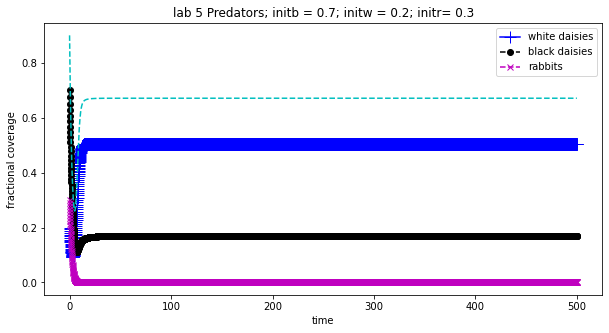

In [49]:
# Now add rabbits
import warnings
warnings.filterwarnings("ignore")
initb=0.7
initw=0.2
initr = 0.3
rabbit_birth=1.0
rabbit_eat=0.2
rabbit_solve_plot(initb=initb,initw=initw,initr=initr,rabbit_birth=rabbit_birth,rabbit_eat=rabbit_eat)

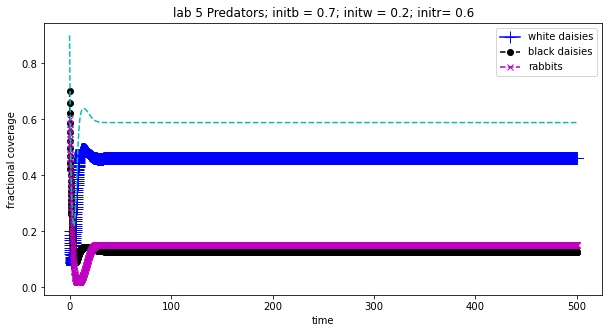

In [50]:
# Now add rabbits
import warnings
warnings.filterwarnings("ignore")
initb=0.7
initw=0.2
initr = 0.6
rabbit_birth=2.0
rabbit_eat=0.5
rabbit_solve_plot(initb=initb,initw=initw,initr=initr,rabbit_birth=rabbit_birth,rabbit_eat=rabbit_eat)

<h2> Fox Problem </h2>

In [26]:
#Import statments - these are duplicates from above, so that code above does not need to be rerun
import context
from collections import namedtuple
from numlabs.lab5.lab5_funs import Integrator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
#New class to solve with foxes.
class Integ57(Integrator):

    def set_yinit(self, initb, initw, initr, initf, rabbit_birth, rabbit_eat,fox_birth,fox_eat):

        #read in 'albedo_white chi S0 L albedo_black R albedo_ground'

#I don't understand what this step is doing.... why is rabbit_birth = initial black conc, and rabbit eat=initial white conc?
#ASK IN CLASS#
        uservars=namedtuple('uservars',self.config['uservars'].keys())
        self.config["uservars"]["rabbit_birth"]=initb #change black daisy inputs
        self.config["uservars"]["rabbit_eat"]=initw #change white daisy input
        self.uservars=uservars(**self.config['uservars'])
        
        #Changing uservars named tuple to include fox_birth and fox_eat, that are input from calling the function rather than the yaml file.
        self.config['uservars']['fox_birth']=fox_birth
        self.config['uservars']['fox_eat']=fox_eat
        uservars_fox=namedtuple('uservars',self.config['uservars'].keys())
        self.uservars=uservars_fox(**self.config["uservars"])
        
      
        #read in 'whiteconc blackconc - now as arguments'

        initvars=namedtuple('initvars', self.config['initvars'].keys())
        self.config['initvars']['blackconc']=initb 
        self.config['initvars']["whiteconc"]=initw
        self.config["initvars"]["rabbits"]=initr
        
        self.initvars=initvars(**self.config["initvars"])

        #Adding initial concentration of foxes to the initvars tuple.  This has to be different than for the rabbits because the tuple has already been defined with rabbits.
        self.config["initvars"]["foxes"]=initf #term for initial concentration of foxes.
        initvars_fox=namedtuple('initvars',self.config['initvars'].keys())
        self.initvars=initvars_fox(**self.config['initvars'])

        self.yinit=np.array(
            [self.initvars.whiteconc,self.initvars.blackconc,self.initvars.rabbits,self.initvars.foxes]) #added foxes
        self.nvars=len(self.yinit)

        return None

    def __init__(self,coeff_file_name, initb, initw, initr, initf, rabbit_birth, rabbit_eat,fox_birth,fox_eat):
            super().__init__(coeff_file_name)
            self.set_yinit(initb,initw,initr,initf, rabbit_birth,rabbit_eat,fox_birth,fox_eat)

    def find_temp(self,yvals):
        """"calculate the temperature over the white and black daisies
        and the planetary equilibrium temperature given the daisy fractions
        
        input: yvals - and array of dimention[2] with the white[0] and black[0]
        output: white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma=5.67e-8 #Stefan Boltzman constant W/m^2/K^4
        user=self.uservars
        bare=1.0-yvals[0]-yvals[1]
        albedo_p=bare*user.albedo_ground + \
            yvals[0]*user.albedo_white+yvals[1]*user.albedo_black
        Te_4=user.S0/4.0*user.L*(1.0-albedo_p)/sigma
        temp_e=Te_4**0.25
        eta=user.R*user.L*user.S0/(4.0*sigma)
        temp_b=(eta*(albedo_p-user.albedo_black)+Te_4)**0.25
        temp_w=(eta*(albedo_p-user.albedo_white)+Te_4)**0.25
        return(temp_w,temp_b,temp_e)

    def derivs5(self, y,t):
        """y[0]=fraction white daisies
            y[1]=fraction black daisies
            no feedback between daisies and albedo_p
            set to ground albedo
            """
        temp_w, temp_b,temp_e=self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0

        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        # Change these lines to include the amount of daisies eaten by rabbits
        f[0] = y[0] * (beta_w * bare - user.chi) - (y[0] * y[2] * rabbit_eat)
        f[1] = y[1] * (beta_b * bare - user.chi) - (y[1] * y[2] * rabbit_eat)

        # calculate ground covered by daisies to calculate change in rabbit population
        total = y[0] + y[1]
        # Calculate rate of change of rabbits:
        f[2] = y[2] *((rabbit_birth * total * (1.0 - y[2])) - user.rabbit_chi)-y[3]*fox_eat

        #Calculate rate of change of foxes.  Assuming they follow the same formula as rabbits but with rabbits substiuted for daisies.
        f[3]=y[3]*((fox_birth*y[2]*(1.0-y[3]))-user.fox_chi)
        return f

    def timeloop5fixed(self):
        """fixed time step with
            estimated errors
            """
        t = self.timevars
        yold = self.yinit
        yError = np.zeros_like(yold)
        yvals = [yold]
        errorList = [yError]
        timeSteps = np.arange(t.tstart, t.tend, t.dt)
        for theTime in timeSteps[:-1]:
            yold, yError, newTime = self.rkckODE5(yold, theTime, t.dt)
            #pdb.set_trace()
            yvals.append(yold)
            errorList.append(yError)
        yvals = np.array(yvals).squeeze()
        errorVals = np.array(errorList).squeeze()
        return (timeSteps, yvals, errorVals)

In [28]:
import warnings
warnings.filterwarnings("ignore")

def fox_solve_plot(initb,initw,initr,initf, rabbit_birth,rabbit_eat,fox_birth,fox_eat):
    theSolver=Integ57('rabbits.yaml', initb=initb, initw=initw, initr=initr, initf=initf, rabbit_birth=rabbit_birth, \
         rabbit_eat=rabbit_eat,fox_birth=fox_birth,fox_eat=fox_eat)
    timeVals, yVals, errorlist=theSolver.timeloop5fixed()
    yvals=pd.DataFrame(yVals,columns=["white","black","rabbits","foxes"])

    thefig, theAx = plt.subplots(1, 1,figsize=(10,5))
    points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
    points.set_markersize(12)
    theLine1, = theAx.plot(timeVals, yvals['black'], '--ko', label='black daisies')
    theLine2, = theAx.plot(timeVals, yvals['rabbits'], '--mx', label='rabbits')
    theLine3, = theAx.plot(timeVals, yvals['white'] + yvals['black'], '--c', label='')
    theLine4, =theAx.plot(timeVals, yvals['foxes'],"--",label="foxes")
    theAx.set_title('lab 5 Predators with Foxes; initb = ' + str(initb) + '; initw = ' + str(initw)+'; initr= '+ str(initr))
    theAx.set_xlabel('time')
    theAx.set_ylabel('fractional coverage')
    out = theAx.legend(loc='best')
    
    plt.show()

In [29]:
# Now add foxes
import warnings
warnings.filterwarnings("ignore")
initb=0.7
initw=0.2
initr = 0.3
initf=0.5
rabbit_birth=1.0
rabbit_eat=0.2
fox_birth=1.0
fox_eat=0.2
fox_solve_plot(initb=initb,initw=initw,initr=initr,initf=initf,rabbit_birth=rabbit_birth,rabbit_eat=rabbit_eat,fox_birth=fox_birth, fox_eat=fox_eat)

AttributeError: 'uservars' object has no attribute 'fox_chi'